In [1]:
!pip install torch torchvision matplotlib

Defaulting to user installation because normal site-packages is not writeable


Epoch [1/10], Step [100/938], Loss: 0.8420
Epoch [1/10], Step [200/938], Loss: 0.5179
Epoch [1/10], Step [300/938], Loss: 0.4498
Epoch [1/10], Step [400/938], Loss: 0.4118
Epoch [1/10], Step [500/938], Loss: 0.4038
Epoch [1/10], Step [600/938], Loss: 0.3532
Epoch [1/10], Step [700/938], Loss: 0.3441
Epoch [1/10], Step [800/938], Loss: 0.3327
Epoch [1/10], Step [900/938], Loss: 0.3269
Epoch [2/10], Step [100/938], Loss: 0.2959
Epoch [2/10], Step [200/938], Loss: 0.2887
Epoch [2/10], Step [300/938], Loss: 0.2967
Epoch [2/10], Step [400/938], Loss: 0.2903
Epoch [2/10], Step [500/938], Loss: 0.2819
Epoch [2/10], Step [600/938], Loss: 0.2601
Epoch [2/10], Step [700/938], Loss: 0.2510
Epoch [2/10], Step [800/938], Loss: 0.2671
Epoch [2/10], Step [900/938], Loss: 0.2741
Epoch [3/10], Step [100/938], Loss: 0.2394
Epoch [3/10], Step [200/938], Loss: 0.2293
Epoch [3/10], Step [300/938], Loss: 0.2299
Epoch [3/10], Step [400/938], Loss: 0.2300
Epoch [3/10], Step [500/938], Loss: 0.2339
Epoch [3/10

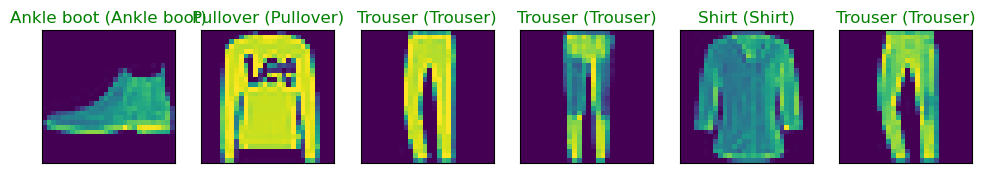

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1. 加载 FashionMNIST 数据集并进行预处理
# 定义数据转换：转换为Tensor并标准化
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 加载训练集
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 加载测试集
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False) # 测试集通常使用较大的batch size

# 定义类别名称
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 2. 设计 CNN 网络
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 卷积层1：输入1通道（灰度图），输出32个特征图，卷积核大小3x3
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 2x2最大池化

        # 卷积层2：输入32通道，输出64个特征图，卷积核大小3x3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 2x2最大池化

        # 全连接层
        self.fc1 = nn.Linear(64 * 7 * 7, 128) # 经过两次2x2池化后，28x28的图像变为7x7
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10) # 输出层，10个类别

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7) # 将特征图展平成一维向量
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

# 实例化网络
model = Net()

# 3. 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. 训练网络
def train(model, train_loader, criterion, optimizer, epochs=5):
    model.train() # 设置模型为训练模式
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad() # 清空梯度
            outputs = model(inputs) # 前向传播
            loss = criterion(outputs, labels) # 计算损失
            loss.backward() # 反向传播计算梯度
            optimizer.step() # 更新权重

            running_loss += loss.item()
            if (i + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
                running_loss = 0.0
    print('Finished Training')

# 开始训练
train(model, train_loader, criterion, optimizer, epochs=10)

# 5. 在测试集上验证网络
def test(model, test_loader, classes):
    model.eval() # 设置模型为评估模式
    correct = 0
    total = 0
    with torch.no_grad(): # 在评估过程中禁用梯度计算
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the 10000 test images: {accuracy:.2f}%')

# 开始测试
test(model, test_loader, classes)

# 可选：查看一些预测结果
def visualize_predictions(model, test_loader, classes, num_images=6):
    model.eval()
    with torch.no_grad():
        dataiter = iter(test_loader)
        images, labels = next(dataiter)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        import matplotlib.pyplot as plt
        import numpy as np

        def imshow(img):
            img = img / 2 + 0.5     # unnormalize
            npimg = img.numpy()
            plt.imshow(np.transpose(npimg, (1, 2, 0)))

        fig = plt.figure(figsize=(12, 4))
        for idx in np.arange(num_images):
            ax = fig.add_subplot(1, num_images, idx+1, xticks=[], yticks=[])
            imshow(images[idx])
            ax.set_title(f"{classes[predicted[idx]]} ({classes[labels[idx]]})",
                         color=("green" if predicted[idx]==labels[idx] else "red"))
        plt.show()

# 可视化一些预测结果
visualize_predictions(model, test_loader, classes)